Start loading
Finish loading
Start preprocessing
Processed data shape: torch.Size([13666, 3, 224, 224]), Labels shape: torch.Size([13666])


/home/kumar.anke/.conda/envs/ml_course_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/kumar.anke/.conda/envs/ml_course_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


start training
Epoch: 0, Train Loss: 0.4005, Validation Loss: 0.2359
Epoch: 1, Train Loss: 0.1550, Validation Loss: 0.1864
Epoch: 2, Train Loss: 0.0602, Validation Loss: 0.1983
Epoch: 3, Train Loss: 0.0277, Validation Loss: 0.2220
Epoch: 4, Train Loss: 0.0161, Validation Loss: 0.2447
Test Accuracy: 0.9452


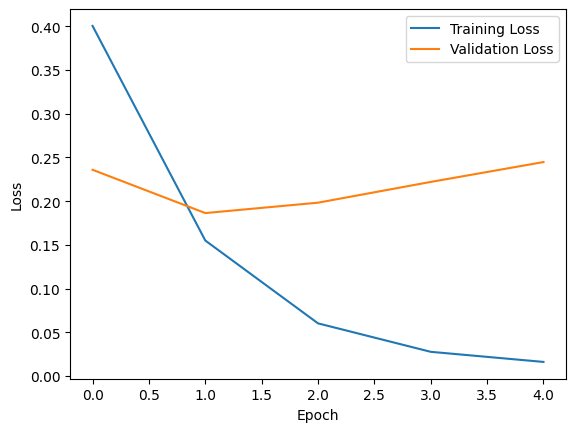

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from PIL import Image
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load data from .npy files
print('Start loading')
class0 = np.load('class_0.npy')
class1 = np.load('class_1.npy')
print('Finish loading')

# Ensure the data is in the shape [num_samples, channels, height, width]
# Assuming the images are originally in shape [height, width, channels]

print('Start preprocessing')

# Separate the labels from the data
# Reshape the data (remove the last element for label, reshape the rest)
def preprocess_and_reshape(data):
    # Remove the last element from each row (label) and reshape the rest
    images = data[:, :-1]  # Remove last element
    labels = data[:, -1]   # Extract last element as the label
    images = images.reshape(-1, 3, 224, 224)  # Reshape into (num_samples, 224, 224, 3)
    return images, labels

# Apply the preprocessing to class0 and class1
class0_images, class0_labels = preprocess_and_reshape(class0)
class1_images, class1_labels = preprocess_and_reshape(class1)

# Combine the arrays and create labels
X = np.concatenate([class0_images, class1_images], axis=0)
y = np.concatenate([class0_labels, class1_labels], axis=0)

# # Define the transformations
# preprocess = transforms.Compose([
#     transforms.ToPILImage(),      # Convert numpy array to PIL image
#     transforms.Resize((224, 224)),  # Resize to (224, 224)
#     transforms.ToTensor(),        # Convert to tensor
# ])

# # Apply transformations to each image and stack into a single tensor
# def preprocess_images(images):
#     processed_images = [preprocess(img) for img in images]
#     return torch.stack(processed_images)

# Apply preprocessing to all images
X_tensor = torch.tensor(X, dtype=torch.float)
y_tensor = torch.tensor(y, dtype=torch.float)

print(f'Processed data shape: {X_tensor.shape}, Labels shape: {y_tensor.shape}')

# Split data into train, validation, and test sets (80%, 10%, 10%)
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the model
class CustomResNet50(nn.Module):
    def __init__(self):
        super(CustomResNet50, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        # Replace the final fully connected layer with a new one for binary classification
        num_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_features, 2)

    def forward(self, x):
        return self.resnet50(x)

model = CustomResNet50()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and optimizer
class_counts = np.bincount(y_tensor.numpy().astype(int))
class_weights = 1.0 / class_counts
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# Training loop
num_epochs = 5
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_state = None

print('start training')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.long()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Validation
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            labels = labels.long()
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * inputs.size(0)
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        # Save the model with the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()

    print(f'Epoch: {epoch}, Train Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')


# Load best model
model.load_state_dict(best_model_state)

# Testing
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.long()
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

# Plot training and validation loss
plt.figure()
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.plot(range(num_epochs), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
